## Fundamental frequency exploration

Exploring to what extent fundamental frequency variance and mean within an audio chunk can predict disagreement.

Dog disagreement episode:

4/9/show_49NxrBHUtto19pgLNAJkHY/6hoNS9LR1Lxb4EzMX72kXR

In [1]:
import librosa 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

In [2]:
# import common analysis functions we've defined
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)

from common.annotation_utils import tp, get_union

In [3]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_style("white", {'font.family':'serif', 'font.serif':'Times Roman'})
sns.set_context("talk")
sns.set_palette("crest")

In [4]:
EPISODE_ID = "6hoNS9LR1Lxb4EzMX72kXR"
START_MIN = 40
FILE_NAME = f"{EPISODE_ID}.ogg"

# Compiled annotations pickle file, generated from compile_annotations.py script
ANNOTATIONS_FILEPATH = '../audio_annotation/compiled_annotations_df.pkl'
# Load annotations
annot_df = pd.read_pickle(ANNOTATIONS_FILEPATH)
# Get union of disagreement annotations
disagreement_times = get_union(annot_df, EPISODE_ID)
print(disagreement_times)

[(2408.65,2410.25), (2414.37,2418.00), (2428.31,2430.46), (2431.61,2434.06), (2443.36,2446.86), (2459.06,2461.41), (2462.95,2463.40), (2467.96,2480.31), (2480.67,2481.62), (2491.71,2502.31), (2504.07,2505.97), (2506.01,2510.46), (2535.68,2539.46), (2540.57,2541.62), (2541.83,2544.27), (2547.43,2553.01), (2553.46,2557.68), (2561.94,2566.79), (2570.80,2573.20), (2575.07,2577.66), (2613.91,2614.96), (2615.09,2617.26), (2617.71,2620.78), (2620.84,2622.94), (2623.41,2625.11), (2625.46,2629.66), (2630.26,2634.26), (2637.54,2639.54), (2640.96,2642.61), (2643.06,2646.41)]


In [5]:
# Load the audio (starting from minute START_MIN) as a waveform "y"
# Store the sampling rate as "sr" (preserve native sampling rate of the file)
start_offset = 60 * START_MIN
y, sr = librosa.load(FILE_NAME, offset = start_offset)

In [6]:
print(f"Shape of waveform: {y.shape}")
print(f"Sampling rate: {sr}")

Shape of waveform: (12148480,)
Sampling rate: 22050


In [7]:
print(f"Number of minutes of excerpt: {(len(y)/sr)/60: .4f}")

Number of minutes of excerpt:  9.1825


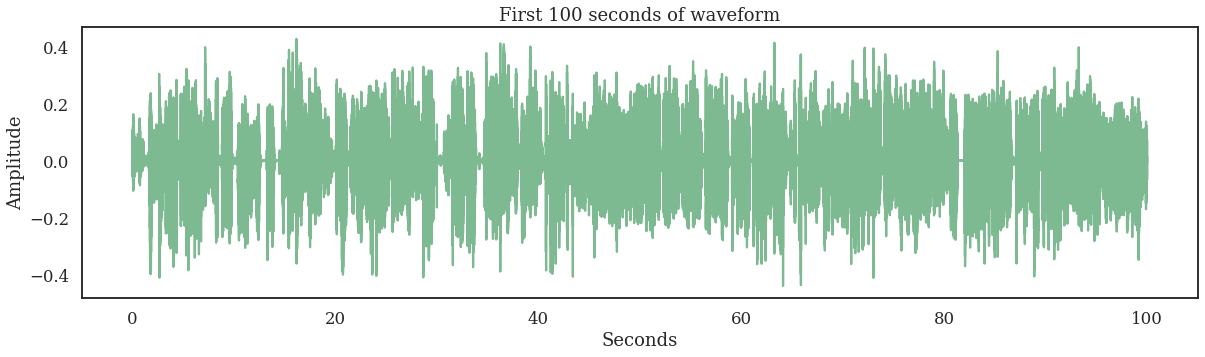

In [8]:
n_seconds = 100
plt.figure(figsize = (20,5))
plt.plot(np.arange(n_seconds * sr)/sr, y[:(n_seconds * sr)])
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.title(f"First {n_seconds} seconds of waveform");

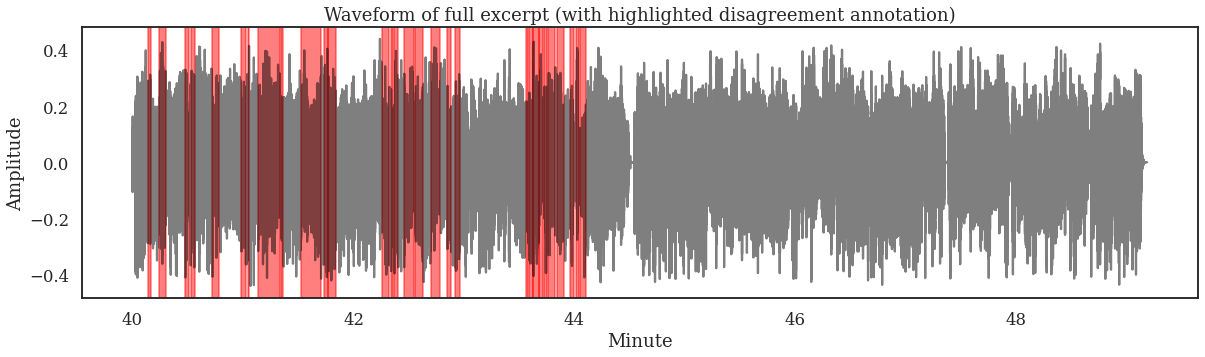

In [9]:
plt.figure(figsize = (20,5))
plt.plot(START_MIN + np.arange(len(y))/(60 * sr), y, alpha = 0.5, color = 'black')
plt.xlabel("Minute")
plt.ylabel("Amplitude")
plt.title(f"Waveform of full excerpt (with highlighted disagreement annotation)")

for w in disagreement_times:
    plt.axvspan(w.start/60, w.end/60, color='red', alpha=0.5)

In [10]:
# Fundamental frequency (F0) estimation using probabilistic YIN (pYIN):

# f0: np array of estimated F0 in Hz
# voiced_flag: True if the frame is voiced (contains a pitched signal)
# voiced_probs: probability frame is voiced

FRAME_LENGTH = 2048
f0, voiced_flag, voiced_probs = librosa.pyin(y, 
                                             sr = sr,
                                             frame_length = FRAME_LENGTH, # length of the frames in samples
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))

Note that the default frame length of 2048 samples means that:

$$(\frac{2048 \text{ samples}}{1 \text{ frame}})(\frac{1 \text{ second}}{22050 \text{ samples}}) \approx 0.0929 \text{ seconds} \approx 93 \text{ milliseconds per frame}$$

In [11]:
print(f"Shape of f0: {f0.shape}")
print(f"Number of minutes in the excerpt: {len(f0) * 2048 / (sr * 60) / 4}")

Shape of f0: (23728,)
Number of minutes in the excerpt: 9.18271806500378


In [12]:
# Get the times (in seconds) corresponding to each frame
f0_times = librosa.times_like(f0)
interval = f0_times[1] - f0_times[0]

print(f"Timestamp corresponding to start of last f0 observation: {START_MIN + f0_times[-1]/60:.4f}")
print(f"Interval between each F0 estimation: {interval:.5f} seconds")

Timestamp corresponding to start of last f0 observation: 49.1823
Interval between each F0 estimation: 0.02322 seconds


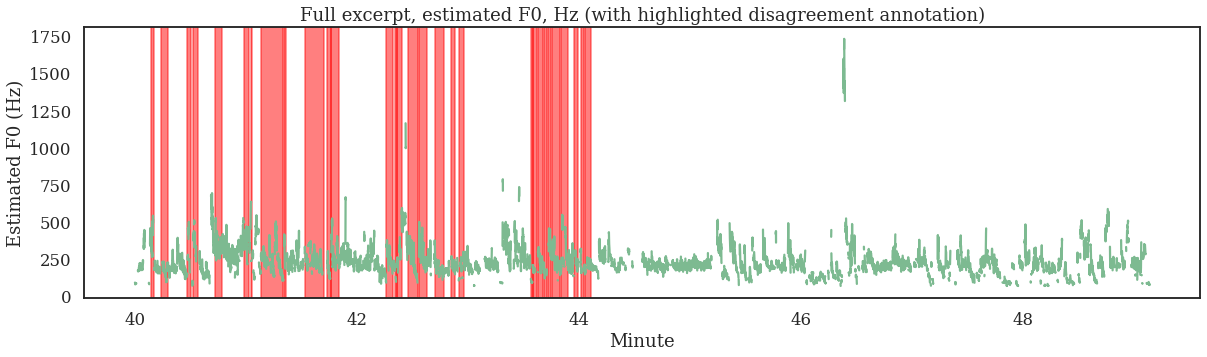

In [13]:
plt.figure(figsize = (20,5))
plt.plot(START_MIN + f0_times/60, f0)
plt.xlabel("Minute")
plt.ylabel("Estimated F0 (Hz)")
plt.title(f"Full excerpt, estimated F0, Hz (with highlighted disagreement annotation)")

for w in disagreement_times:
    plt.axvspan(w.start/60, w.end/60, color='red', alpha=0.5)

Number of frames per chunk (to discretize on): 215


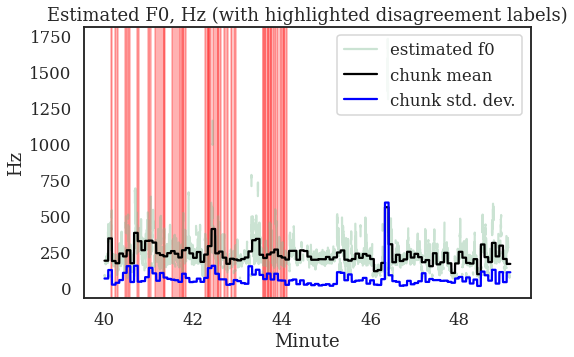

In [56]:
# Define the length of the window in seconds over which to aggregate the F0 (fundamental frequency) estimates

WINDOW_LENGTH_SECS = 5
n_frames_per_window = int(WINDOW_LENGTH_SECS  // interval)
print(f"Number of frames per chunk (to discretize on): {n_frames_per_window}")
window_means = []; window_vars = []; window_max = []; window_min = []; window_nan_count = []
window_times_secs = []

for i in range(0, len(f0_times) - n_frames_per_window, n_frames_per_window):
    chunk_f0 = f0[i:(i+n_frames_per_window)]
    window_means.append(np.nanmean(chunk_f0))
    window_vars.append(np.nanvar(chunk_f0))
    window_max.append(np.nanmax(chunk_f0))
    window_min.append(np.nanmin(chunk_f0))
    window_nan_count.append(np.count_nonzero(np.isnan(chunk_f0)))
    window_times_secs.append(f0_times[i])

_means_plot = [j for i in window_means for j in n_frames_per_window * [i]]
_sd_plot = [np.sqrt(j) for i in window_vars for j in n_frames_per_window * [i]]

#plt.figure(figsize = (20,5))

plt.plot(START_MIN + f0_times/60, f0, alpha = 0.4, label = 'estimated f0')
plt.title(f"Estimated F0, Hz (with highlighted disagreement labels)")

plt.plot((START_MIN + f0_times/60)[:len(_means_plot)], 
         _means_plot[:len(_means_plot)], color = 'black', label = 'chunk mean')
plt.ylabel("Hz")
plt.xlabel("Minute")

plt.plot((START_MIN + f0_times/60)[:len(_sd_plot)], 
                       _sd_plot[:len(_sd_plot)], 
                       color = 'blue', label = 'chunk std. dev.')
plt.legend(loc = 'upper right')

for w in disagreement_times:
    plt.axvspan(w.start/60, w.end/60, color='red', alpha=0.3)

In [47]:
start_sec = START_MIN * 60
window_interval = window_times_secs[1] - window_times_secs[0]
print(f"Interval between each window: {window_interval:.4f} seconds")

chunked_f0_times = [tp(start_sec + i, start_sec + i + window_interval) for i in window_times_secs]
disagreement_labels = 1*np.array([any([t in d for d in disagreement_times]) for t in chunked_f0_times])
print(f"Proportion of chunks which are disagreement: {disagreement_labels.mean():4f}")

Interval between each window: 4.9923 seconds
Proportion of chunks which are disagreement: 0.318182


In [48]:
print(len(window_means))
print(disagreement_labels.shape)

110
(110,)


In [49]:
global_avg_f0 = np.nanmean(f0)
global_var = np.nanvar(f0)
print(global_avg_f0)
print(global_var)

228.52725590205915
11621.346772026574


In [50]:
# fill nulls (usually when there is silence) with zero
#X = np.array([window_means, window_vars, window_min, window_max, window_nan_count]).T
#X = np.array([window_means, window_vars, window_nan_count]).T
X = np.array([window_means, window_vars]).T
#X[np.isnan(X)] = 0

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, disagreement_labels, 
                                                    test_size = 0.2, 
                                                    stratify = disagreement_labels,
                                                    shuffle = True,
                                                    random_state = 0)

In [53]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print(classification_report(y_train, y_pred_train))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred_test));

Accuracy of logistic regression classifier on train set: 0.60
              precision    recall  f1-score   support

           0       0.75      0.63      0.68        60
           1       0.41      0.54      0.46        28

    accuracy                           0.60        88
   macro avg       0.58      0.58      0.57        88
weighted avg       0.64      0.60      0.61        88

Accuracy of logistic regression classifier on test set: 0.64
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.44      0.57      0.50         7

    accuracy                           0.64        22
   macro avg       0.61      0.62      0.61        22
weighted avg       0.67      0.64      0.65        22



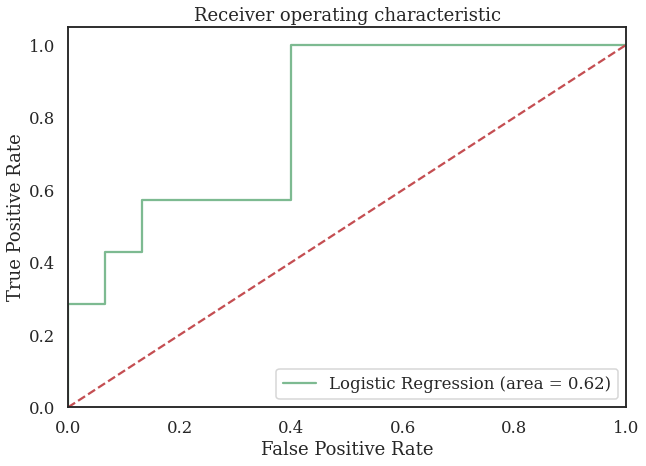

In [57]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [58]:
# Print coefficients of logistic regression:

feature_names = ['f0_mean', 'f0_var']
# multiply regression coefficients by each feature's standard deviation (to ignore scale)
pd.DataFrame(np.std(X_train, 0) * logreg.coef_, columns =  feature_names)

,f0_mean,f0_var
0,0.738751,-0.587716


In [25]:
y_pred_test

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [26]:
y_pred_train

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1])

In [59]:
print(y_test.mean())

0.3181818181818182
